# Training Transformer AE

How important is spatial information? In this notebook, we train a Transformer autoencoder that only considers temporal dependencies to answer this question.

In [19]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import TransformerAutoencoder
from parameters import TransformerAEParameters, TrainingParameters
from datautils import get_morning_data, get_rstae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_rstae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, train_transformerae, test_transformerae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc, discrete_fp_delays_loc
import torch.nn as nn
from tqdm import tqdm

import random
import os
import torch_geometric
seed=42
torch_geometric.seed_everything(seed)

### Time Series Sequencing

In [20]:
def sequence_transformer(data, timesteps, hide_anomalies=False):
    sequence = []
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not

        combined = np.array(data_t)
        combined = np.swapaxes(combined, 0, 1)
        combined = torch.tensor(combined, dtype=torch.float32)
        
        curr_data = combined[:,-1,:]
        sequence.append([combined, curr_data])

    return sequence, kept_indices

### Loading Hyperparameters

In [21]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)
hide_anomalies = False
optimal_hyperparams = load_best_parameters('transformer',hide_anomalies=hide_anomalies)
optimal_hyperparams

{'epochs': 8,
 'hidden_dim': 64,
 'latent_dim': 1,
 'learning_rate': 1.0466663567906674e-06,
 'num_layers': 3,
 'timesteps': 7}

In [22]:
training_params = TrainingParameters( 
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=optimal_hyperparams['epochs'],
)

In [23]:
# These were manually tuned due to the increased computational demands of larger transformer models
# Additionally, the graph-based models led to much more reasonable reconstructions
hyperparams = TransformerAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    hidden_dim=optimal_hyperparams['hidden_dim'],
    num_heads=1,
    num_layers=optimal_hyperparams['num_layers'],
    sequence_length=training_params.timesteps
)

In [24]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_transformer(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_transformer(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)

100%|██████████| 2873/2873 [00:14<00:00, 202.15it/s]


In [25]:
# ae = TransformerAutoencoder(hyperparams)

### Model Training or Loading

In [26]:
using_pretrained =True

In [28]:
if not using_pretrained:
    ae, losses = train_transformerae(params=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, f'transformerae_{hide_anomalies}_{seed}')
else:
    ae = load_model(TransformerAutoencoder, hyperparams, f'transformerae_{hide_anomalies}_{seed}')

In [ ]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [29]:
from training import compute_anomaly_threshold_transformerae

In [30]:
thresh = compute_anomaly_threshold_transformerae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 10487/10487 [00:34<00:00, 301.37it/s]


### Loading Test Data

In [31]:
_, df_test_data, _ = get_full_data()

In [32]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_transformer(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4793/4793 [00:28<00:00, 166.11it/s]


In [33]:
test_errors, test_recons_speeds, test_true_speeds = test_transformerae(test_data, mse_weights, ae)

In [34]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
# crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [35]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]



/tmp/ipykernel_2427655/3884504702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive
/tmp/ipykernel_2427655/3884504702.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_2427655/3884504702.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [36]:
results = discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)
path_results = 'saved_results_loc/transformer/'
if not os.path.exists(path_results):
    os.makedirs(path_results)
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)


100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]

Found FPR of 0.009950248756218905 for 0.01
Found FPR of 0.024875621890547265 for 0.025
Found FPR of 0.04933665008291874 for 0.05
Found FPR of 0.10033167495854063 for 0.1
Found FPR of 0.19817578772802655 for 0.2
FPR 1% gives mean delay of -3.8333333333333335 +/- 10.036046144883064 with mean. distance of 3.8499999999999996 +/- 1.9170289512680814 while missing 0.7%.
FPR 2.5% gives mean delay of -2.0 +/- 8.979142498033985 with mean. distance of 3.2666666666666666 +/- 2.1826334756181325 while missing 0.6%.
FPR 5% gives mean delay of -4.375 +/- 7.24029522878729 with mean. distance of 3.3249999999999997 +/- 2.1072790512886517 while missing 0.6%.
FPR 10% gives mean delay of -5.0 +/- 7.623975340988453 with mean. distance of 3.091666666666667 +/- 2.316501792694224 while missing 0.6%.
FPR 20% gives mean delay of -5.6 +/- 7.052659073002182 with mean. distance of 5.35 +/- 4.8197510309143565 while missing 0.5%.


In [ ]:
path_results = 'saved_results/transformer/'
results = discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

100%|██████████| 1000/1000 [00:27<00:00, 35.85it/s]

Found FPR of 0.01 for 0.01
Found FPR of 0.025416666666666667 for 0.025
Found FPR of 0.050416666666666665 for 0.05
Found FPR of 0.10041666666666667 for 0.1
Found FPR of 0.2 for 0.2
FPR 1% gives mean delay of -8.0 +/- 0.0 while missing 0.9166666666666666%.
FPR 2.5% gives mean delay of -3.75 +/- 9.555757426808196 while missing 0.6666666666666667%.
FPR 5% gives mean delay of -5.083333333333333 +/- 8.243263242726686 while missing 0.5%.
FPR 10% gives mean delay of -7.0625 +/- 7.759822404539939 while missing 0.33333333333333337%.
FPR 20% gives mean delay of -6.3 +/- 9.228217596047463 while missing 0.16666666666666663%.


In [ ]:
_, df_test_data, _ = get_full_data()
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_transformer(test_data, training_params.timesteps, hide_anomalies=False)
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]
results=discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

### Compute FPR / Crash Detection Delay Tradeoff

In [18]:
calculate_auc(test_errors,anomaly_labels)

0.6063721707818931

In [23]:
import importlib
import metrics
importlib.reload(metrics)
delay_results = np.array(metrics.find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 98/98 [00:00<00:00, 275.80it/s]


In [25]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/transformerae_fp_delay.csv')

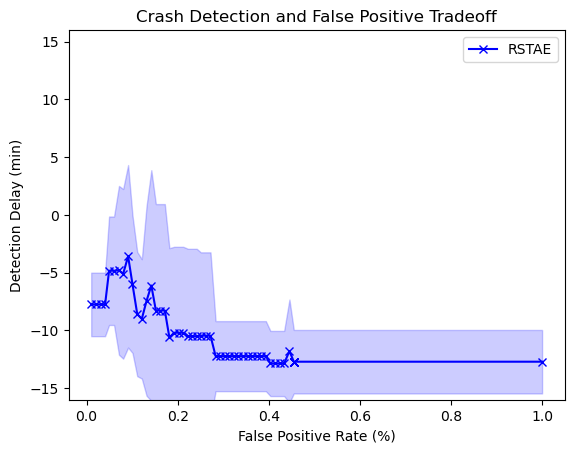

In [26]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [27]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:28<00:00, 35.66it/s]

Found FPR of 0.010025062656641603 for 0.01
Found FPR of 0.024644945697577275 for 0.025
Found FPR of 0.04928989139515455 for 0.05
Found FPR of 0.0998329156223893 for 0.1
Found FPR of 0.19883040935672514 for 0.2
FPR 1% gives mean delay of -7.75 +/- 2.75 while missing 0.8333333333333334%.
FPR 2.5% gives mean delay of -7.75 +/- 2.75 while missing 0.8333333333333334%.
FPR 5% gives mean delay of -4.833333333333333 +/- 4.6963342678684565 while missing 0.75%.
FPR 10% gives mean delay of -6.0 +/- 5.951190357119041 while missing 0.5%.
FPR 20% gives mean delay of -10.2 +/- 7.4404300950953095 while missing 0.16666666666666663%.


### Compute AUC

In [18]:
calculate_auc(test_errors, anomaly_labels)

0.3328330761316872

### Copmute Detection Delay Histogram on Full Dataset

In [29]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [30]:
full_sequence, kept_full_indices = sequence_transformer(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/18230 [00:00<?, ?it/s]

100%|██████████| 18230/18230 [05:41<00:00, 53.35it/s]


In [31]:
full_errors, _, _ = test_transformerae(full_sequence, mse_weights, ae)

In [32]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [33]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [01:50<00:00,  9.08it/s]


In [34]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


Found FPR of 0.10043719721139076 for 0.1


In [35]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

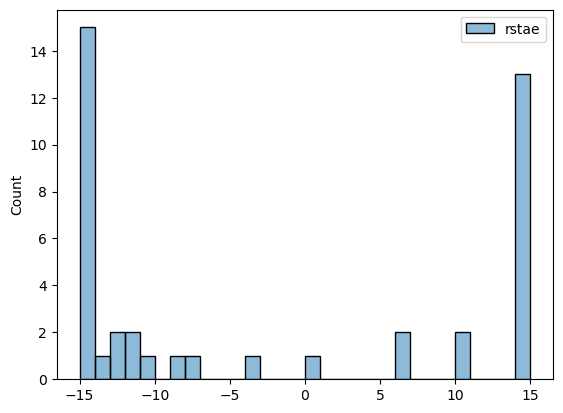

In [36]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [37]:
np.save('./saved_results/transformerae10delays.npy', np.array(delay)/2)

In [38]:
tmp, df_clean_test_data, _ = get_full_data()

In [39]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_transformer(clean_test_data, training_params.timesteps, hide_anomalies=True)

100%|██████████| 4790/4790 [00:31<00:00, 154.04it/s]


In [40]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_transformerae(clean_test_data, mse_weights, ae)

In [41]:
np.mean(clean_test_errors)

0.03319541

In [42]:
test_recons_speeds[:480].shape

(480, 196)

In [43]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [44]:
# data.to_csv('./saved_results/full_results_test_transformerae.csv')

In [45]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_transformerae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [46]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [47]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()